# Executive Summary

One of the most critical factors in online sales and customer relatioonship managemnt that can make or break online stores long term profitability is incomplete transactions. If a company can predict weather a shopping basket is not going to checked out and stays there for days or weeks, it can take a more targeted appraoch to running promotions or introduce policies to reduce them.
This is a sophisticated evolution from the traditional approach to to incentivize all transactions equally to reduce incomplete transaction as it allows companies to spend their marketing budget and focus of their decision (policies) more effectively.
It is this managerial usefulness of being able to predict incomplete transactions hat attracted me to do this assignment. 
In this project, I have mainly used classical data prediction techniques such as classification tree and logistic regression and slightly more complicated algorithms such as Adaboost and xgboost to obtain accuracy. I have outlines the stpes involved in deriving the insight from existing dataset and prediction of the new dataset. However, before modelling steps, exploratory data analysis reveals very insightful stories of our data and we get to confim them as we find our way through. In the end, we details the model selection and future work.

# Import and Clean Data


In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix  
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'white')

In [3]:
import os
print(os.listdir("data/"))

['customer_data.csv', 'mydata.csv', 'new_transactions.csv', 'transactions_data.csv']


In [4]:
customers = pd.read_csv('data/customer_data.csv')
customers.head()

,Customer ID,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points
0,CID_7225,63,Female,Urban,Married,High School,68000.0,1,6.0
1,CID_10008,49,Male,Urban,Divorced,Graduate,62500.0,1,4.0
2,CID_6297,51,Female,Suburban,Widowed,Graduate,58500.0,0,NaN
3,CID_5520,77,Female,Urban,Widowed,Graduate,52000.0,1,19.0
4,CID_6454,28,Male,Suburban,Single,NaN,27500.0,0,NaN


In [5]:
transactions = pd.read_csv('data/transactions_data.csv')
transactions.head()

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction
0,TRID_21210,CID_12160,2020-03-22,8,3,22.88,7.54,3.11,7,0
1,TRID_83725,CID_11410,2020-01-08,4,2,22.80,4.79,7.51,15,0
2,TRID_10532,CID_12776,2020-02-19,5,3,14.80,7.96,8.98,16,0
3,TRID_88885,CID_9162,2020-02-17,5,3,13.04,6.98,5.61,11,0
4,TRID_68790,CID_14594,2020-01-06,14,4,9.60,9.25,6.62,14,1


In [6]:
customers.columns.values

array(['Customer ID', 'Age', 'Gender', 'Region', 'Marital Status',
       'Education', 'Household Income', 'Loyalty Card', 'Loyalty Points'],
      dtype=object)

In [7]:
transactions.columns.values

array(['Transaction ID', 'Customer ID', 'Date', 'Total Items',
       'Unique Items', 'Total Sales', 'Discounted Sales',
       'Browsing Duration (minutes)', 'Number of Clicks',
       'Incomplete Transaction'], dtype=object)

## Checking the data types of all the columns

In [8]:
customers.dtypes

Customer ID          object
Age                   int64
Gender               object
Region               object
Marital Status       object
Education            object
Household Income    float64
Loyalty Card          int64
Loyalty Points      float64
dtype: object

In [9]:
transactions.dtypes

Transaction ID                  object
Customer ID                     object
Date                            object
Total Items                      int64
Unique Items                     int64
Total Sales                    float64
Discounted Sales               float64
Browsing Duration (minutes)    float64
Number of Clicks                 int64
Incomplete Transaction           int64
dtype: object

## Exploring missing values

In [ ]:
customers.isnull().sum()

In [11]:
transactions.isnull().sum()

Transaction ID                 0
Customer ID                    0
Date                           0
Total Items                    0
Unique Items                   0
Total Sales                    0
Discounted Sales               0
Browsing Duration (minutes)    0
Number of Clicks               0
Incomplete Transaction         0
dtype: int64

In [12]:
customers.shape

(2407, 9)

In [13]:
transactions.shape

(5000, 10)

There are quite number of missing values in loyalty points. Lets explore more tto check how we can deal with missing values of loyalty points.

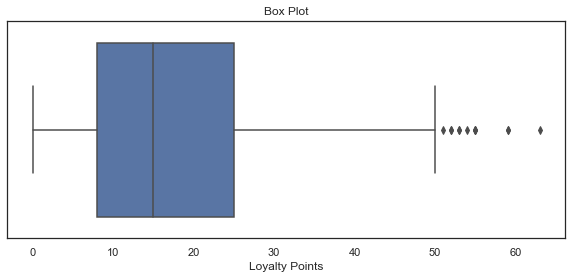

In [14]:
def Box_plots(df):
    plt.figure(figsize=(10, 4))
    plt.title("Box Plot")
    sns.boxplot(df)
    plt.show()
    
Box_plots(customers['Loyalty Points'])

# Outlier detection for loyalty points

Outliers can play a very important role when we want to decide on what to do with the missing values. I would Explore the influence of outliers on loyalty point distribution in total and then identify outliers and distribution of this variable in more details.

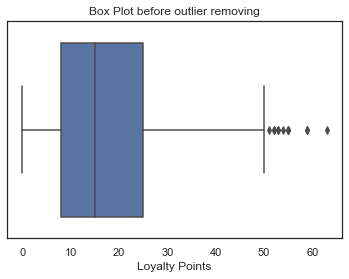

mean:  17.308873720136518
median:  15.0
Our Data:  (2407, 9)


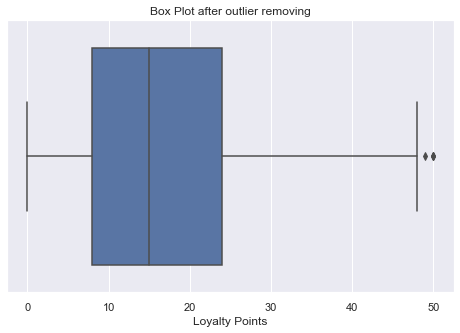

mean:  16.91810344827586
median:  15.0
Our Data:  (2395, 9)


In [15]:
sns.boxplot(customers['Loyalty Points'])
plt.title("Box Plot before outlier removing")
plt.show()
print('mean: ',customers['Loyalty Points'].mean())
print('median: ',customers['Loyalty Points'].median())
print('Our Data: ',customers.shape)
sns.set(rc={'figure.figsize':(8,5)})

def drop_outliers(df, field_name):
    iqr = 1.5 * (np.nanpercentile(df[field_name], 75) - np.nanpercentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.nanpercentile(df[field_name], 75))].index, inplace = True)
    df.drop(df[df[field_name] < (np.nanpercentile(df[field_name], 25) - iqr)].index, inplace = True)
    
    sns.boxplot(df[field_name])
    plt.title("Box Plot after outlier removing")
    plt.show()
    print('mean: ',df[field_name].mean())
    print('median: ',df[field_name].median())
    print('Our Data: ',customers.shape)
    
    
drop_outliers(customers, 'Loyalty Points')
sns.set(rc={'figure.figsize':(8,5)})



It can be seen that after removing major outliers the mean drastically changed, but not median. We can still get rid of 
two other outliers by passing the dataframe through the function but removing those two does not make any 
changes to the mean or medianan.


It appears that we have plenty of missing values in Loyalty Points. Let's further investigate this particular column and get to know our data set in more depth. 


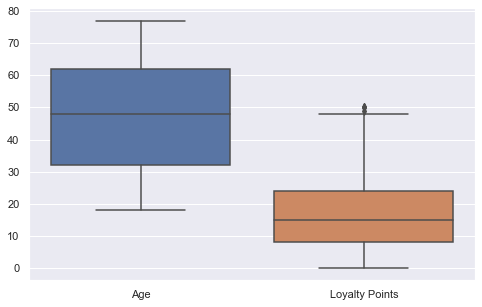

In [19]:
sns.boxplot(data=customers[['Age', 'Loyalty Points']])
sns.set(rc={'figure.figsize':(8,5)})

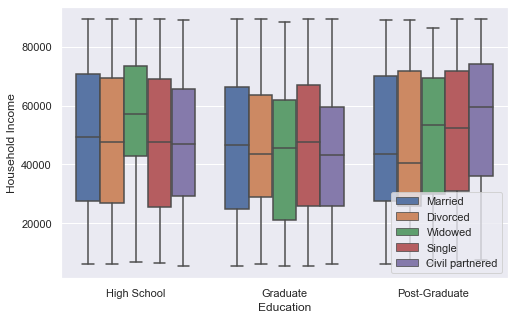

In [20]:
g = sns.boxplot(x="Education", y="Household Income", hue="Marital Status", data=customers)
g.legend(loc='lower right', ncol=1)
sns.set(rc={'figure.figsize':(8,5)})

I plotted Age and Loyalty Points as they are numeric values in our dataset with almost the same range (House Hold income can be investigated seperately) and all three variables can't fit in one plot together due to having different ranges.

It appears that loyality points has some outliers. Data set with outliers has significantly different mean and standard deviation. So, outliers are importnat as they can be silent killer!
whit that said I would like to further analyse the Loyality points. Again if we are interested we can do the same analysis for all the columns.

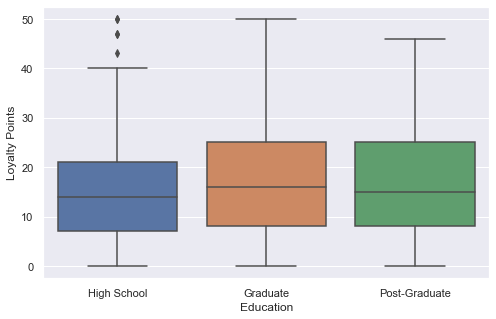

In [21]:
sns.boxplot(x="Education", y="Loyalty Points", data=customers)
sns.set(rc={'figure.figsize':(8,5)})

Plotting Loyalty points versus education. It seems that we have some outliers in high school category, but how about if we zoom in a bit more and add more attribute to this plot?

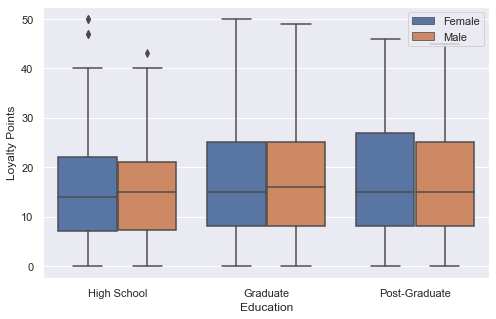

In [22]:
g = sns.boxplot(x="Education", y="Loyalty Points", hue="Gender", data=customers)
g.legend(loc='upper right', ncol=1)
sns.set(rc={'figure.figsize':(8,5)})

Breaking it down using Gender variable we can see that outliers are revealing themselves. At this stage I would like to make sure I know the outliers for Loyalty Points in more depth. This is because number of outliers can be a good ground to make decision about how to deal with missing values.

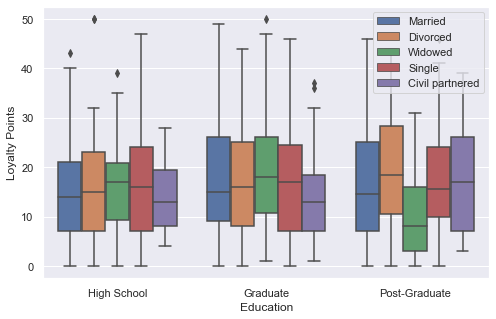

In [23]:
g = sns.boxplot(x="Education", y="Loyalty Points", hue="Marital Status", data=customers)
g.legend(loc='upper right', ncol=1)
sns.set(rc={'figure.figsize':(8,5)})

This time replacing gender with marital status reveals different set of outliers.
Per the outlier analysis, we know that there are is not any major outlier as a whole, but we still can see them per various categories which gives us a good knowledge about how to treat the null values in this particular column.

# Imputing null values for loyality
Depending on the business need we might want to  get rid of rows with null values or not. In this scenario null values are quite a lot for Loyality Points and removing them can significantly affect the dataset. Therefore, per our earlier analysis, where we worked out influence of removing outliers on the mean and median we noticed median is not being affected that much. It might be a good idea to impute null values rather than totally removing them.
Additionally, plotting loyality points versus education with martial status shows us in each category we still have outliers. If the column has a lot of outliers the median would probably be more useful to replace missing values since it is more resistant to them. This way, we are attempting to preserve aspects of the data.


In [24]:
customers['Loyalty Points'] = customers['Loyalty Points'].fillna(customers['Loyalty Points'].median())

In [25]:
customers.isnull().sum()

Customer ID           0
Age                   0
Gender                0
Region                0
Marital Status        0
Education           184
Household Income      0
Loyalty Card          0
Loyalty Points        0
dtype: int64

In [26]:
transactions.isnull().sum()

Transaction ID                 0
Customer ID                    0
Date                           0
Total Items                    0
Unique Items                   0
Total Sales                    0
Discounted Sales               0
Browsing Duration (minutes)    0
Number of Clicks               0
Incomplete Transaction         0
dtype: int64

We will deal with missing values in categorical variables (Education) in the later stages.

# Join Dataset

In [27]:
customers['Customer ID'] = customers['Customer ID'].astype("string")
transactions['Customer ID'] = transactions['Customer ID'].astype("string")

In [28]:
customers.dtypes

Customer ID          string
Age                   int64
Gender               object
Region               object
Marital Status       object
Education            object
Household Income    float64
Loyalty Card          int64
Loyalty Points      float64
dtype: object

In [29]:
transactions.dtypes

Transaction ID                  object
Customer ID                     string
Date                            object
Total Items                      int64
Unique Items                     int64
Total Sales                    float64
Discounted Sales               float64
Browsing Duration (minutes)    float64
Number of Clicks                 int64
Incomplete Transaction           int64
dtype: object

In [30]:
# Merging the two datasets
mydata = pd.merge(transactions, customers, left_on='Customer ID', right_on='Customer ID', how= 'left')

# just to have the dataset locally
# mydata.to_csv('mydata.csv', index=False)
mydata = pd.read_csv('data/mydata.csv')
mydata['Education'] = mydata['Education'].fillna('unknown')
mydata.head()

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points
0,TRID_21210,CID_12160,2020-03-22,8,3,22.88,7.54,3.11,7,0,19,Female,Rural,Divorced,High School,21000.0,0,15.0
1,TRID_83725,CID_11410,2020-01-08,4,2,22.80,4.79,7.51,15,0,41,Female,Urban,Divorced,High School,20000.0,1,5.0
2,TRID_10532,CID_12776,2020-02-19,5,3,14.80,7.96,8.98,16,0,42,Female,Urban,Married,Graduate,9000.0,0,15.0
3,TRID_88885,CID_9162,2020-02-17,5,3,13.04,6.98,5.61,11,0,77,Male,Urban,Divorced,High School,84500.0,1,21.0
4,TRID_68790,CID_14594,2020-01-06,14,4,9.60,9.25,6.62,14,1,30,Male,Rural,Single,Graduate,53500.0,0,15.0


In [31]:
mydata.shape

(5000, 18)

In [32]:
mydata.isnull().sum()

Transaction ID                 0
Customer ID                    0
Date                           0
Total Items                    0
Unique Items                   0
Total Sales                    0
Discounted Sales               0
Browsing Duration (minutes)    0
Number of Clicks               0
Incomplete Transaction         0
Age                            0
Gender                         0
Region                         0
Marital Status                 0
Education                      0
Household Income               0
Loyalty Card                   0
Loyalty Points                 0
dtype: int64

We can confim all the transactions have corresponding customer ID. Therefore, no further missing values.

# One-Hot-Encoding

In [33]:
#Let's convert all the categorical variables into dummy variables

mydata_dummies = pd.get_dummies(mydata.iloc[:,3:])
mydata_dummies.head()

,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction,Age,Household Income,Loyalty Card,...,Region_Urban,Marital Status_Civil partnered,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education_Graduate,Education_High School,Education_Post-Graduate,Education_unknown
0,8,3,22.88,7.54,3.11,7,0,19,21000.0,0,...,0,0,1,0,0,0,0,1,0,0
1,4,2,22.80,4.79,7.51,15,0,41,20000.0,1,...,1,0,1,0,0,0,0,1,0,0
2,5,3,14.80,7.96,8.98,16,0,42,9000.0,0,...,1,0,0,1,0,0,1,0,0,0
3,5,3,13.04,6.98,5.61,11,0,77,84500.0,1,...,1,0,1,0,0,0,0,1,0,0
4,14,4,9.60,9.25,6.62,14,1,30,53500.0,0,...,0,0,0,0,1,0,1,0,0,0


In [34]:
mydata_dummies.columns.values

array(['Total Items', 'Unique Items', 'Total Sales', 'Discounted Sales',
       'Browsing Duration (minutes)', 'Number of Clicks',
       'Incomplete Transaction', 'Age', 'Household Income',
       'Loyalty Card', 'Loyalty Points', 'Gender_Female', 'Gender_Male',
       'Region_Rural', 'Region_Suburban', 'Region_Urban',
       'Marital Status_Civil partnered', 'Marital Status_Divorced',
       'Marital Status_Married', 'Marital Status_Single',
       'Marital Status_Widowed', 'Education_Graduate',
       'Education_High School', 'Education_Post-Graduate',
       'Education_unknown'], dtype=object)

# Correlations in Data

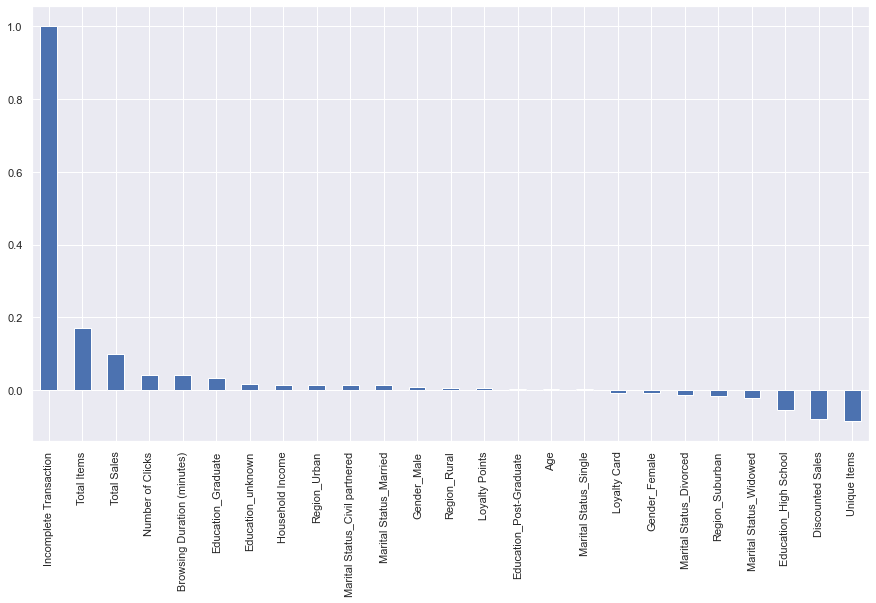

In [35]:
#Get Correlation of incomplete transaction with other variables:
plt.figure(figsize=(15,8))
mydata_dummies.corr()['Incomplete Transaction'].sort_values(ascending = False).plot(kind='bar')

Total items, total sales and number clicks seem to be positively correlated with incomplete transactions. This is while unique items, discounted sales and education at high school level seem to be negatively correlated with incomplete transaction. It means, the more unique items, the more discounted items and when customer is having high school education will lead into a complete transaction.
This is interesting to infer that customer with more discounted items in their basket are more determine to complete their purchase! Additionally, more browsing time and higher number of clicks contribute more towards incomplete transactions, this might show that customers are not too sure about their purchase and need more time?! or they get disappointed after some time?!




# Data Exploration and manipulation

Let us first start with exploring our data set, to better understand the patterns in the data and potentially form some hypothesis. First we will look at the distribution of individual variables and then slice and dice our data for any interesting trends.

## Find and Assess categorical variables

It is important to identify categorical columns in our data and cast them to pd.categorical as it can help in future stages. This is becuase pandas normally casts variables to "object", that might not be something we require always.

In [37]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]

In [38]:
# Making a copy of our dataframe
df = mydata.copy()
summarize_categoricals(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
Transaction ID,"[TRID_21210, TRID_83725, TRID_10532, TRID_8888...",5000,0
Customer ID,"[CID_12160, CID_11410, CID_12776, CID_9162, CI...",2096,0
Date,"[2020-03-22, 2020-01-08, 2020-02-19, 2020-02-1...",91,0
Total Items,"[8, 4, 5, 14, 6, 7, 10, 3, 2, 11, 9, 15, 12, 1...",20,0
Unique Items,"[3, 2, 4, 1, 5, 6, 0, 7]",8,0
Total Sales,"[22.88, 22.8, 14.8, 13.04, 9.6, 19.52, 13.2, 1...",380,0
Discounted Sales,"[7.54, 4.79, 7.96, 6.98, 9.25, 5.36, 9.82, 5.6...",919,0
Browsing Duration (minutes),"[3.11, 7.51, 8.98, 5.61, 6.62, 3.45, 6.07, 7.1...",878,0
Number of Clicks,"[7, 15, 16, 11, 14, 8, 12, 10, 13, 19, 9, 5, 1...",20,0
Incomplete Transaction,"[0, 1]",2,0


In [39]:
def find_categorical(df, cutoff=10):
    """
        Function to find categorical columns in the dataframe.
        Setting threshold for categories to 10
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

Variables with more than 10 levels (our threshold =10) will be casted to categorical.

In [40]:
df = to_categorical(find_categorical(df), df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Transaction ID               5000 non-null   object  
 1   Customer ID                  5000 non-null   object  
 2   Date                         5000 non-null   object  
 3   Total Items                  5000 non-null   int64   
 4   Unique Items                 5000 non-null   category
 5   Total Sales                  5000 non-null   float64 
 6   Discounted Sales             5000 non-null   float64 
 7   Browsing Duration (minutes)  5000 non-null   float64 
 8   Number of Clicks             5000 non-null   int64   
 9   Incomplete Transaction       5000 non-null   category
 10  Age                          5000 non-null   int64   
 11  Gender                       5000 non-null   category
 12  Region                       5000 non-null   category
 13  Mar

## Removing unnecessary columns

Since Customer ID, Data, Transaction ID columns do not provide any relevant information in predicting the incomplete transactions, we can delete them.
Of course, date can be used if we cast the column to actual date/time format.

## Create independent variables

In [41]:
x = df.drop(columns = ['Incomplete Transaction', 'Date', 'Transaction ID', 'Customer ID'])
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Total Items                  5000 non-null   int64   
 1   Unique Items                 5000 non-null   category
 2   Total Sales                  5000 non-null   float64 
 3   Discounted Sales             5000 non-null   float64 
 4   Browsing Duration (minutes)  5000 non-null   float64 
 5   Number of Clicks             5000 non-null   int64   
 6   Age                          5000 non-null   int64   
 7   Gender                       5000 non-null   category
 8   Region                       5000 non-null   category
 9   Marital Status               5000 non-null   category
 10  Education                    5000 non-null   category
 11  Household Income             5000 non-null   float64 
 12  Loyalty Card                 5000 non-null   category
 13  Loy

### Create dependent variables

In [42]:
y = df['Incomplete Transaction']
y

0       0
1       0
2       0
3       0
4       1
       ..
4995    1
4996    1
4997    1
4998    1
4999    0
Name: Incomplete Transaction, Length: 5000, dtype: category
Categories (2, int64): [0, 1]

In [43]:
categorical_columns = list(x.select_dtypes(include='category').columns)
numeric_columns = list(x.select_dtypes(exclude='category').columns)

numeric_columns
categorical_columns

['Unique Items',
 'Gender',
 'Region',
 'Marital Status',
 'Education',
 'Loyalty Card']

## Demographics and variable distributions

Let us first understand the distribution of some of the variables with highest positive or negarive correlation to our dependent variable (incomplete transaction).

#### Gender Distribution

Slightly more than a half of the customers in our data set are female while the other half are male. This slight difference can verify why gender is not significantly correlated with our response variable.

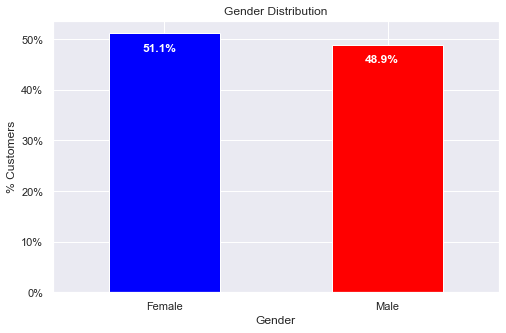

In [44]:
colors = ['blue','red']
ax = (mydata['Gender'].value_counts()*100.0 /len(mydata)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

#### Loyalty Card Holders

The same goes to loyalty card holders. There are only 48.7% of the customers who are having Loyalty Card and just slightly more than half of our customers in the data don't have loyalty card.

Text(0.5, 1.0, '% of Loyalty Card Holders')

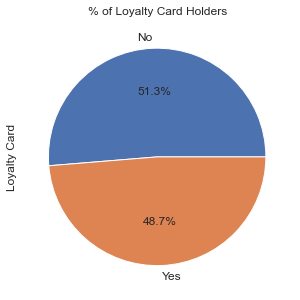

In [45]:
ax = (mydata['Loyalty Card'].value_counts()*100.0 /len(mydata))\
.plot.pie(autopct='%.1f%%',labels = ['No', 'Yes'], figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Loyalty Card',fontsize = 12)
ax.set_title('% of Loyalty Card Holders', fontsize = 12)

In [46]:
df2 = pd.melt(mydata, id_vars=['Customer ID'], value_vars=['Gender','Marital Status'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3

Customer ID                                           \
value          Civil partnered Divorced  Female    Male Married  Single   
variable                                                                  
Gender                     NaN      NaN  2556.0  2444.0     NaN     NaN   
Marital Status           330.0   1002.0     NaN     NaN  2184.0  1074.0   

                        
value          Widowed  
variable                
Gender             NaN  
Marital Status   410.0

#### Total items

As we saw total items is highly correlated with incomplete transaction. After looking at the below histogram we can see that a lot of customers have 3 to 7 items in their basket, while small portion have below 3 items and number of customers rarely have more than 7 items in their baskets.

In [ ]:
ax = sns.distplot(mydata['Total Items'], hist=True, kde=False, bins=int(180/9),
            color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Total Items')
ax.set_title('Number of Transactions by their Total items')

#### Total Sales

Since total sales has also a high correlation I am curios to invesitage it as well.

Text(0.5, 1.0, 'Number of Transactions by their Total Sales')

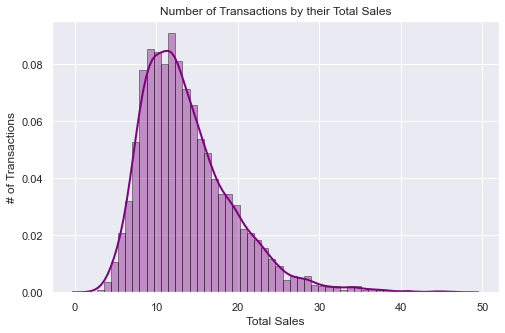

In [48]:
ax = sns.distplot(mydata['Total Sales'], hist=True, kde=True, 
            color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Total Sales')
ax.set_title('Number of Transactions by their Total Sales')

According to the above graph we can see almost a similar pattern as total items. Majority of total sales are between 7 to 15 pounds which aligns with the previous graph and skewed in the same way.

To understand the above graph, lets first look at the number of transaction vs three variables.

Text(0.5, 1.0, 'Number of Transactions by their Number of Clicks')

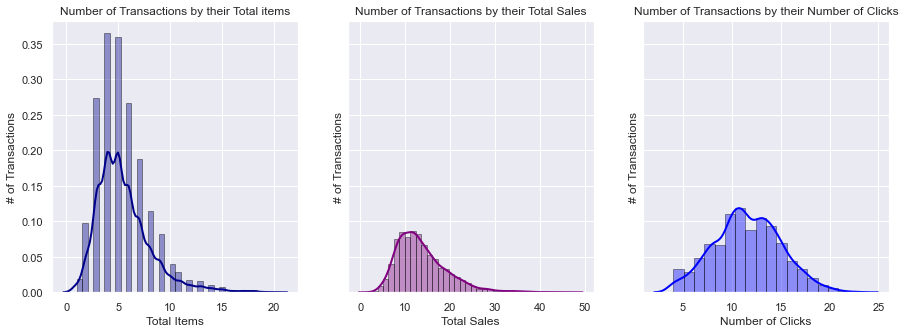

In [49]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (15,5))

ax = sns.distplot(mydata['Total Items'], hist=True, kde=True, bins=int(180/5),
            color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
                  ax=ax1)
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Total Items')
ax.set_title('Number of Transactions by their Total items')

ax = sns.distplot(mydata['Total Sales'], hist=True, kde=True, bins=int(180/5),
            color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
                  ax=ax2)
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Total Sales')
ax.set_title('Number of Transactions by their Total Sales')


ax = sns.distplot(mydata['Number of Clicks'], hist=True, kde=True, bins=int(180/10),
            color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
                  ax=ax3)
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Number of Clicks')
ax.set_title('Number of Transactions by their Number of Clicks')

Interestingly, our top three positively corelated variables are skewed in almost the same way. When plotting the number of clicks on the right hand side of the above plot. Showing most of the customers clicks are between 10 to 14.

#### Unique Items

Highest negative correlation with our response variable. We can see most of the unique items in customers baskets are between 2 to 4 and the highest is three.

Text(0.5, 1.0, 'Number of Transactions by Uniqe Items')

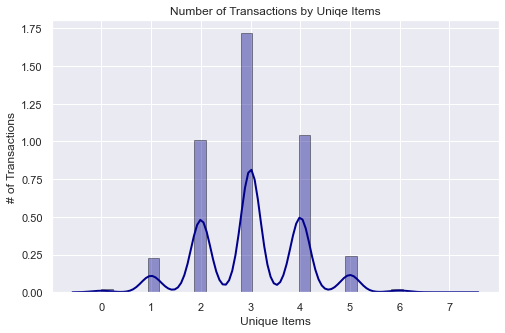

In [50]:
ax = sns.distplot(mydata['Unique Items'], hist=True, kde=True, 
            color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Unique Items')
ax.set_title('Number of Transactions by Uniqe Items')

#### Discounted sales

After unique items, this attribute has the highest negative correlation. 

Text(0.5, 1.0, 'Number of Transactions by Discounted Sales')

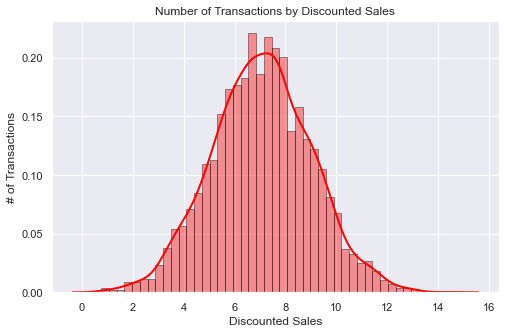

In [51]:
ax = sns.distplot(mydata['Discounted Sales'], hist=True, kde=True, 
            color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Discounted Sales')
ax.set_title('Number of Transactions by Discounted Sales')

#### Education

Lets first look at the number of transactions by different educations. This is because per our correlation plot education plays an important role and I would like to investigate its interaction with other highly correlated variables.

Text(0.5, 1.0, '# of Transactions by Education')

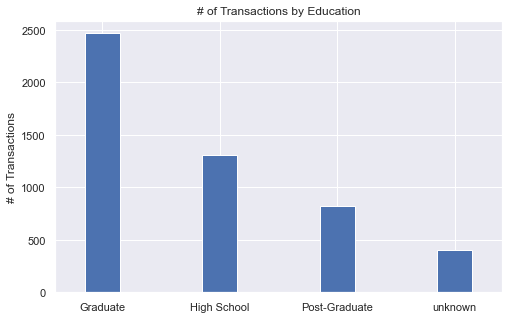

In [52]:
ax = mydata['Education'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Transactions')
ax.set_title('# of Transactions by Education')

As we can see from this graph most of the transactions have been done by Graduate customers. While there are lower number of customers with High School and post graduate education levels.

Let's explore discounted sales based on education. In other words interaction of these two.

Text(0.5, 1.0, 'Post-Graduate')

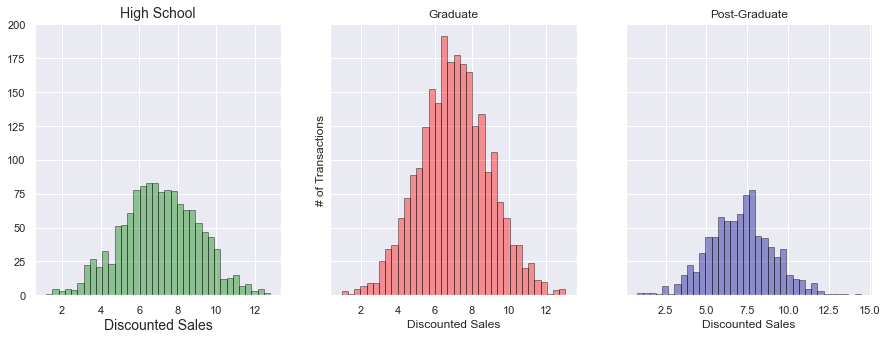

In [53]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (15,5))

ax = sns.distplot(mydata[mydata['Education']=='High School']['Discounted Sales'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'green',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_xlabel('Discounted Sales',size = 14)
ax.set_title('High School',size = 14)

ax = sns.distplot(mydata[mydata['Education']=='Graduate']['Discounted Sales'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'red',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_ylabel('# of Transactions')
ax.set_xlabel('Discounted Sales')
ax.set_title('Graduate')


ax = sns.distplot(mydata[mydata['Education']=='Post-Graduate']['Discounted Sales'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Discounted Sales')
ax.set_title('Post-Graduate')

While the difference between high school and postgraduate is not much in terms of highest amount of discount. The discounted items distribution among high school category is much wider and skewed slighly, meaning that majority of the transaction among high school level are using discounted items. This is also what we saw in the earlier chart on correlation with the incomplete transaction.

#### Others

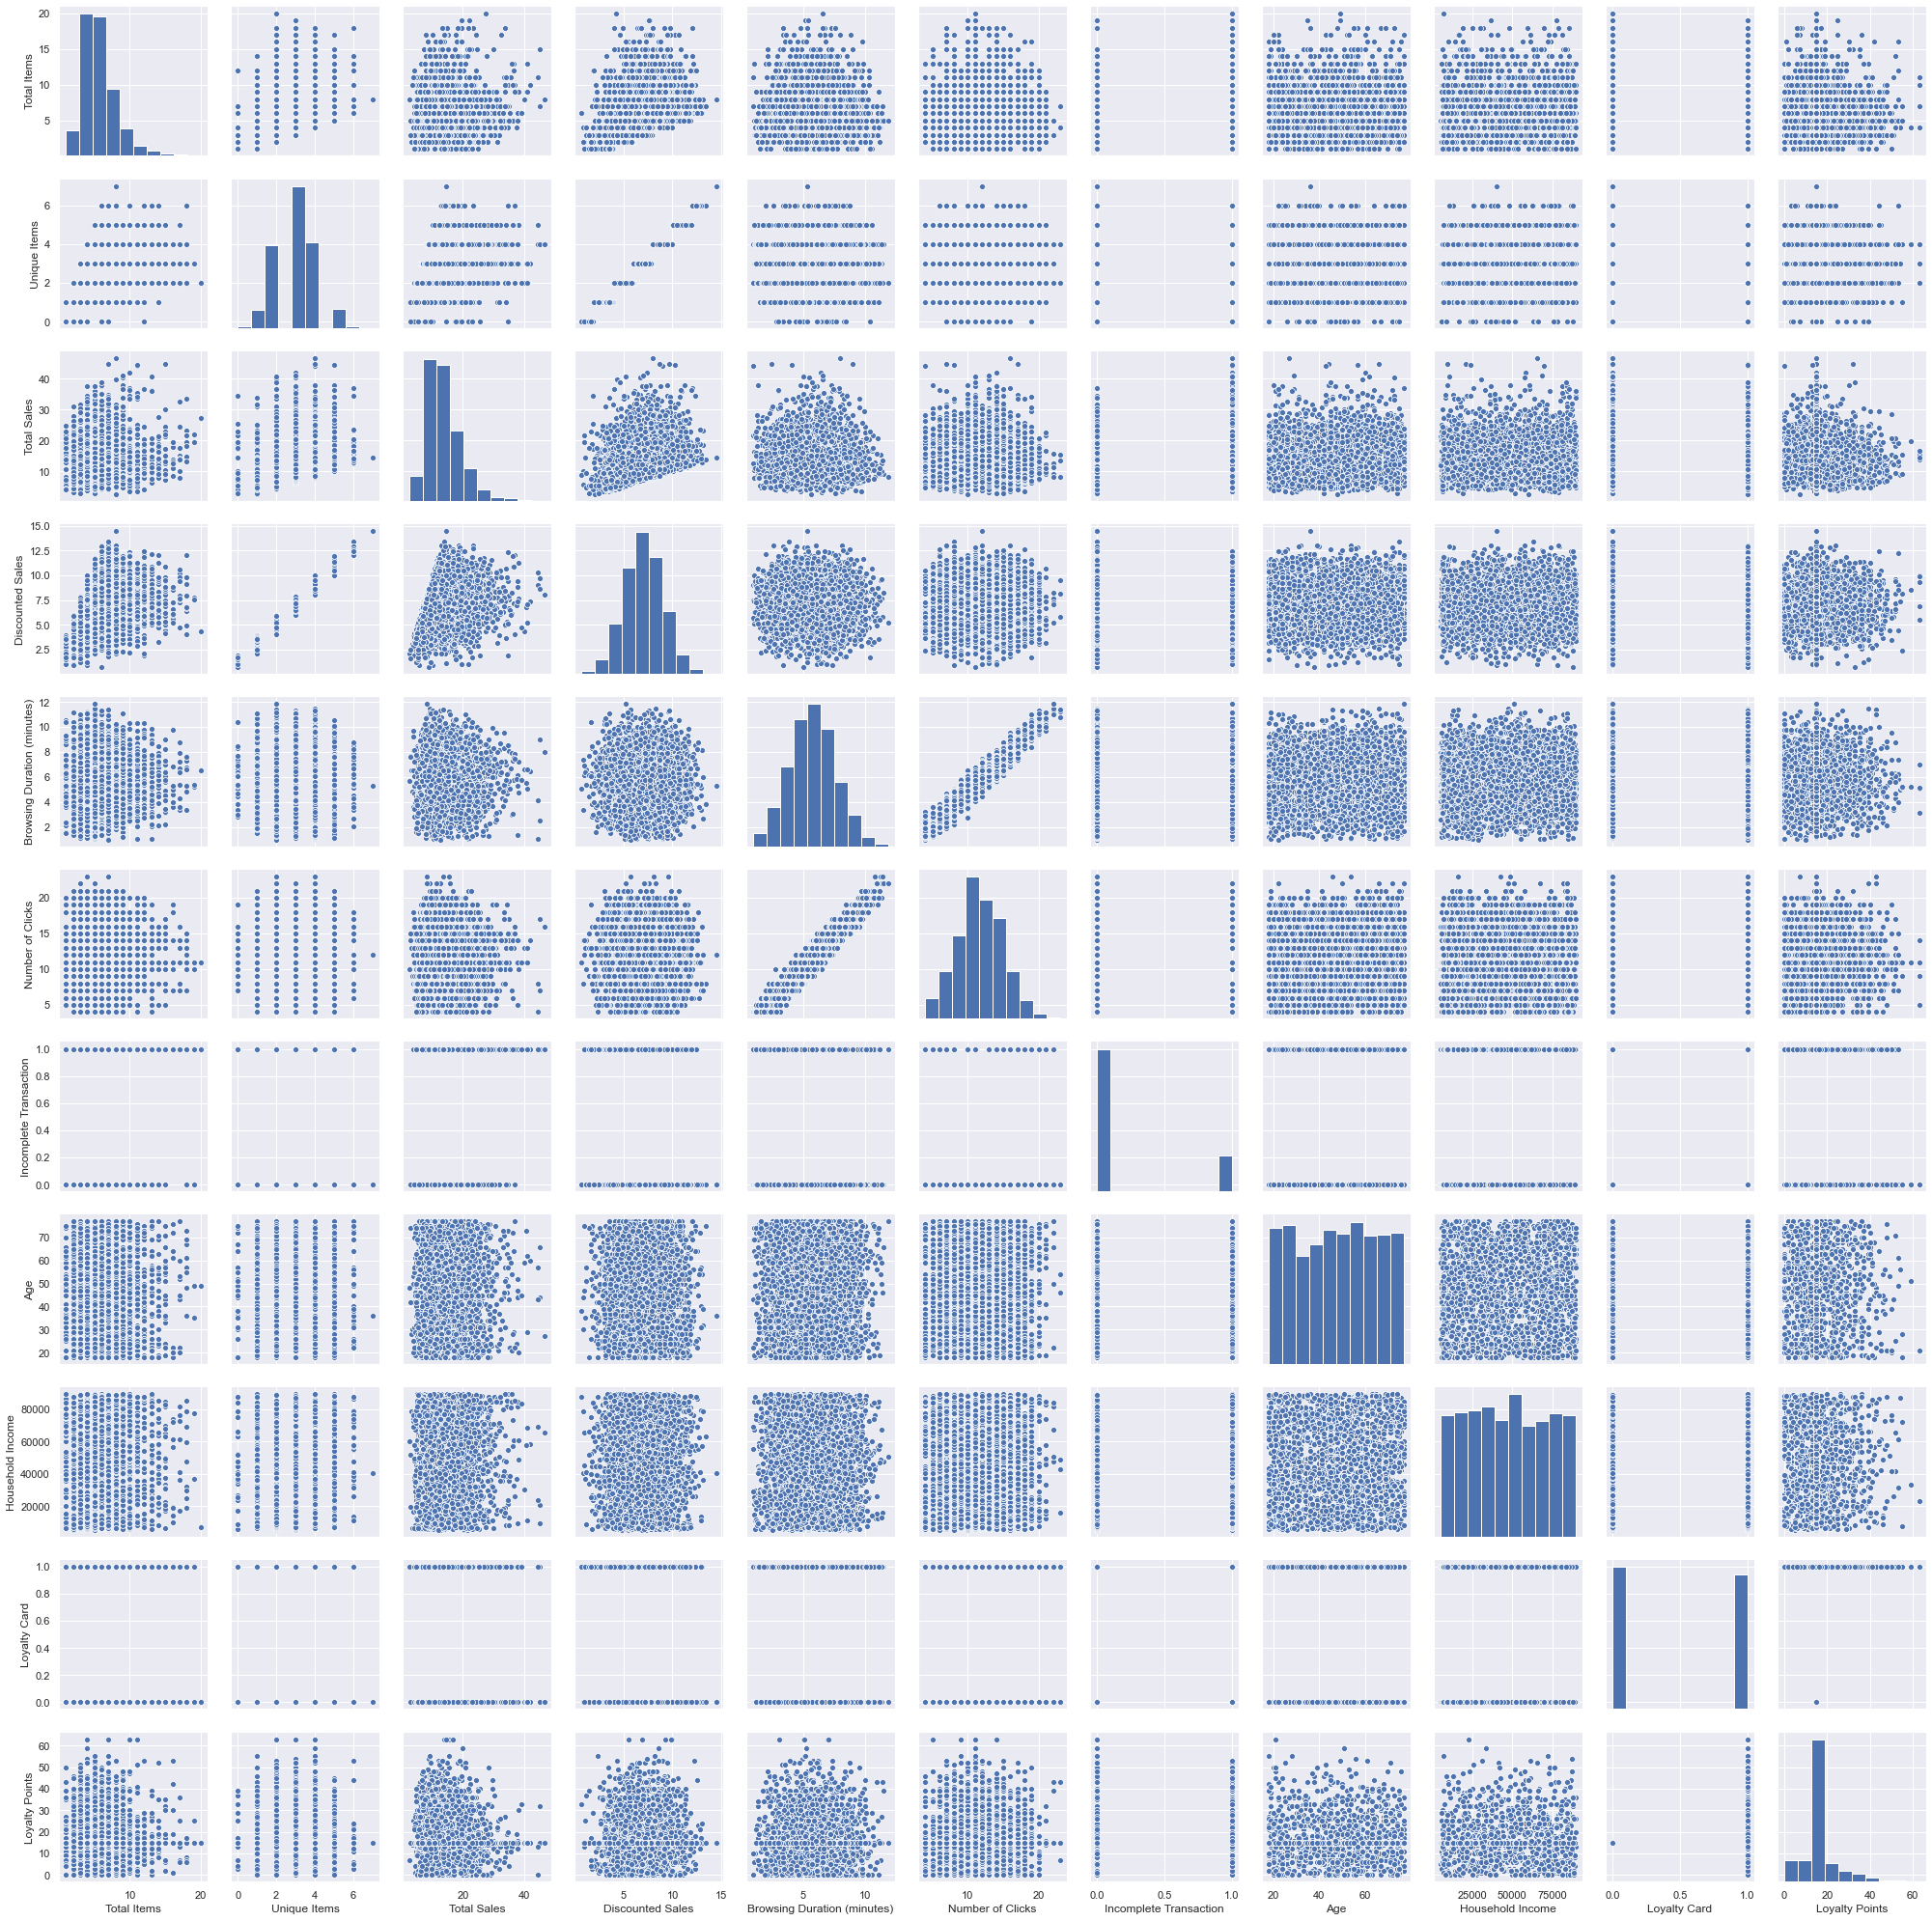

In [60]:
sns.pairplot(mydata)

Looking at pair plots of our data we can see:
- High positive correlation between Browsing time and number of clicks
- High positive correlation discounted sales and unique items
- Positive correlation between discounted sales with two other attributes, total sales and total items

Let us now look at the distribution of attributes of transctions:

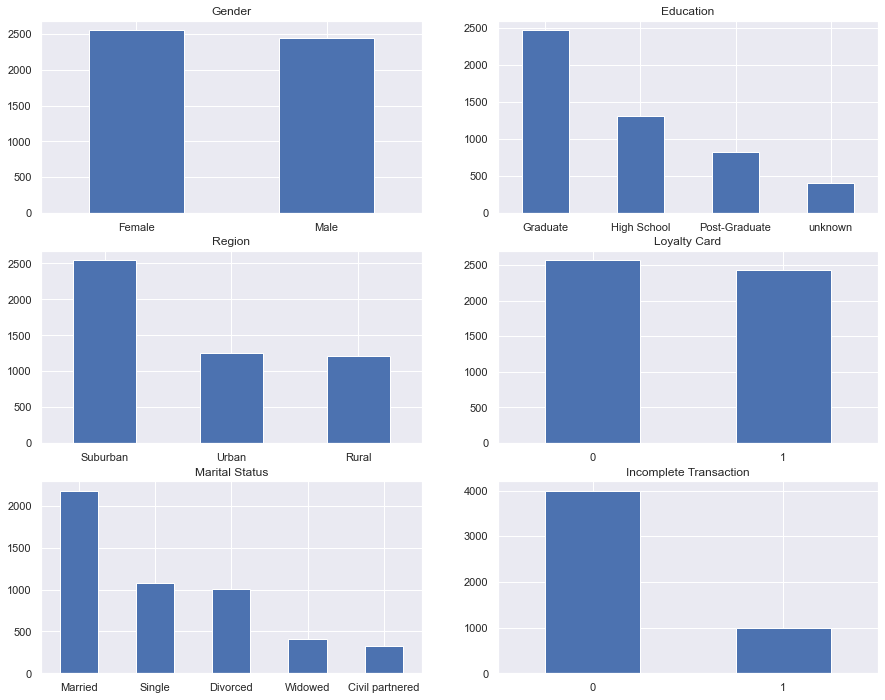

In [54]:
attr = ['Gender', 'Region', 'Marital Status',
       'Education', 'Loyalty Card', 'Incomplete Transaction']

fig, axes = plt.subplots(nrows = 3,ncols = 2,figsize = (15,12))
for i, item in enumerate(attr):
    if i < 3:
        ax = mydata[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = mydata[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = mydata[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

#### Distribution of Incomplete Transaction

Finally, let's take a closer look (The bottom right distribution plot) at out predictor variable (Incomplete Transaction) and understand its interaction with other important variables as was found out in the correlation plot.

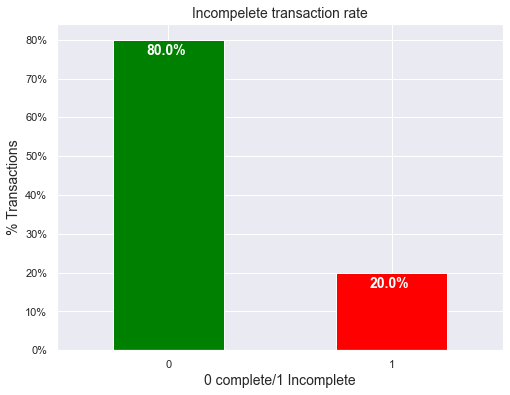

In [55]:
colors = ['green','red']
ax = (mydata['Incomplete Transaction'].value_counts()*100.0 /len(mydata)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Transactions',size = 14)
ax.set_xlabel('0 complete/1 Incomplete',size = 14)
ax.set_title('Incompelete transaction rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold',
           size = 14)

In our data, 80% of the transactions are complete. Clearly the data is skewed as we would expect a large majority of transactions are complete. This is important to keep in mind for our modelling as skewedness could lead to a lot of false negatives. We will handle this issue in the modelling section on how to avoid skewedness in the data.

In [56]:
mydata[mydata["Incomplete Transaction"] == 0].shape

(4000, 18)

In [57]:
mydata[mydata["Incomplete Transaction"] == 1].shape

(1000, 18)

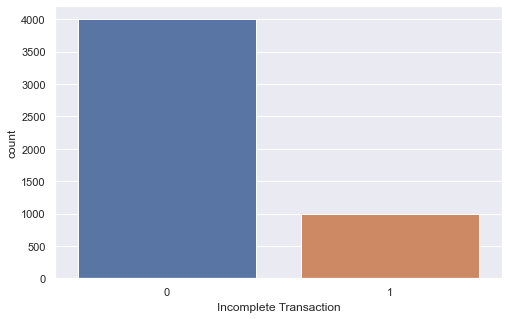

In [58]:
sns.countplot(x=mydata['Incomplete Transaction'])

The class imbalance in the training data is too significant to ignore. The label (0) representing complete has 4000 records, while Incomplete (1) has 1000 records. The models needs to take this into account. You could use under sampling techniques to address this skew in training data such as:
- Resample the training set.
- Use K-fold Cross-Validation
- Ensemble different resampled datasets
- Resample with different ratios

### Interactions

#### Incomplete transaction Vs total items

As we can see in the below plot transactions with higher number of items tend to remain incomplete more. This verifies the strong positive correlation we saw earlier.

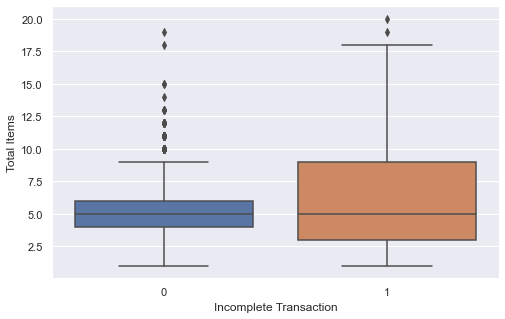

In [59]:
sns.boxplot(x=mydata['Incomplete Transaction'], y=mydata['Total Items'])

#### Incomplete Transaction vs unique items

Similar to what we saw in correlation plot the transactions with more unique items tend to complete.

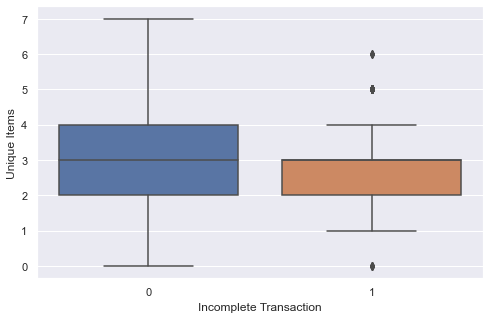

In [60]:
sns.boxplot(x=mydata['Incomplete Transaction'], y=mydata['Unique Items'])

#### Incomplete Transaction vs Education

So far we noticed education plays a significant role in our data as different levels of this categorical variable explains the variability in our response variable. 
Per below chart, we can easily see why high school education contributes more towards complete transaction as the third highest correlation. It has 84 percent positive rate towards completing transactions. On the other hand graduate level has only 79 percent.

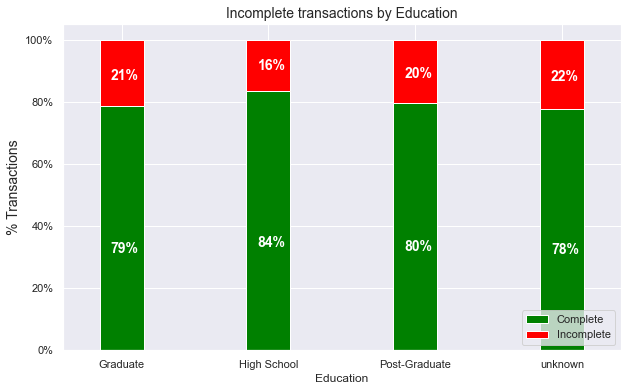

In [61]:
colors = ['green','red']
edu_incom = mydata.groupby(['Education','Incomplete Transaction']).size().unstack()

ax = (edu_incom.T*100.0 / edu_incom.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors, 
                                                    legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Incomplete Transaction')
ax.set_ylabel('% Transactions',size = 14)
ax.set_title('Incomplete transactions by Education',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)
    ax.legend(['Complete', 'Incomplete'],loc='lower right')

#### Incomplete transaction vs Marital status: 

To investigate and verify other slightly correlated categorical variables to our response variable. We can see that widowed status has the highest percentage of complete transaction with 83 percent and that is why this particular category marked significant compared to the other levels in this variable.

In [ ]:
colors = ['green','red']
edu_incom = mydata.groupby(['Marital Status','Incomplete Transaction']).size().unstack()

ax = (edu_incom.T*100.0 / edu_incom.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors, 
                                                    legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Incomplete Transaction')
ax.set_ylabel('% Transactions',size = 14)
ax.set_title('Incomplete transactions by Marital status',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)
    ax.legend(['Complete', 'Incomplete'],loc='lower right')

#### Incomplete transaction vs total sales

It seems that there is a higher rate of incomplete trnasactions when total sales are higher. This can be seen when we look at total sales after 25.

Text(0.5, 1.0, 'Distribution of Total Sales by Incompelte Transactions')

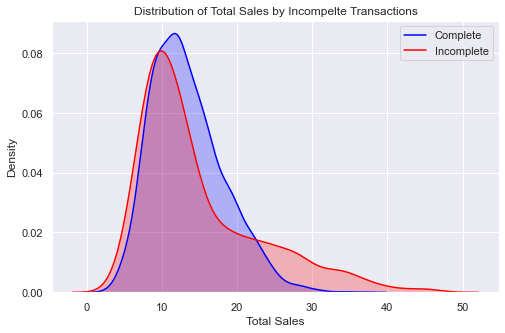

In [63]:
ax = sns.kdeplot(mydata[mydata["Incomplete Transaction"] == 0]['Total Sales'],
                color="Blue", shade = True)
ax = sns.kdeplot(mydata[mydata["Incomplete Transaction"] == 1]['Total Sales'],
                ax =ax, color="Red", shade= True)
ax.legend(["Complete","Incomplete"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Sales')
ax.set_title('Distribution of Total Sales by Incompelte Transactions')

#### Incomplete transaction vs Discounted items

Again, we can see the below graph verifies the correlation. It seems that there is a higher chance of having complete transactions when discounted sales are higher.

Text(0.5, 1.0, 'Distribution of Total Sales by Incompelte Transactions')

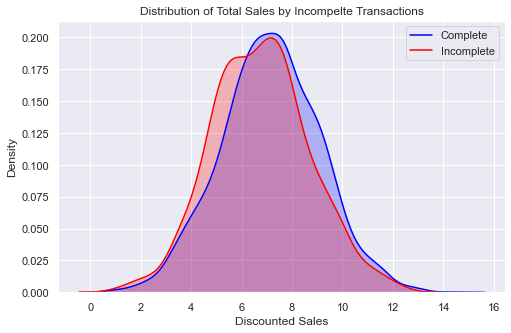

In [64]:
ax = sns.kdeplot(mydata[mydata["Incomplete Transaction"] == 0]['Discounted Sales'],
                color="Blue", shade = True)
ax = sns.kdeplot(mydata[mydata["Incomplete Transaction"] == 1]['Discounted Sales'],
                ax =ax, color="Red", shade= True)
ax.legend(["Complete","Incomplete"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Discounted Sales')
ax.set_title('Distribution of Total Sales by Incompelte Transactions')

## Predictive models

In [65]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_roc(y_true, y_pred, title):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    #print(fpr, tpr, prec, rec)
    plt.plot(fpr, tpr)
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(y_true,y_pred),3)))
    plt.legend(loc='best')
    plt.plot([0,1], [0,1])
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.grid(b=True, which='both')
    plt.title(title)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.show()
    
    return roc_auc_score(y_true,y_pred)

## Getting the Data ready for ML

In [66]:
y = mydata_dummies['Incomplete Transaction'].values
y

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [67]:
len(y)

5000

In [68]:
X = mydata_dummies.drop(columns = ['Incomplete Transaction'])
X

,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Age,Household Income,Loyalty Card,Loyalty Points,...,Region_Urban,Marital Status_Civil partnered,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education_Graduate,Education_High School,Education_Post-Graduate,Education_unknown
0,8,3,22.88,7.54,3.11,7,19,21000.0,0,15.0,...,0,0,1,0,0,0,0,1,0,0
1,4,2,22.80,4.79,7.51,15,41,20000.0,1,5.0,...,1,0,1,0,0,0,0,1,0,0
2,5,3,14.80,7.96,8.98,16,42,9000.0,0,15.0,...,1,0,0,1,0,0,1,0,0,0
3,5,3,13.04,6.98,5.61,11,77,84500.0,1,21.0,...,1,0,1,0,0,0,0,1,0,0
4,14,4,9.60,9.25,6.62,14,30,53500.0,0,15.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6,1,4.88,3.65,1.87,4,50,19500.0,1,34.0,...,1,0,0,0,0,1,1,0,0,0
4996,1,1,14.00,3.57,4.44,10,39,77000.0,0,15.0,...,0,0,0,0,1,0,1,0,0,0
4997,6,2,38.88,4.69,5.73,11,45,83500.0,1,33.0,...,0,0,0,0,0,1,1,0,0,0
4998,2,2,13.44,5.86,6.55,13,47,62000.0,1,16.0,...,0,0,0,0,0,1,1,0,0,0


## Scaling all the variables to a range of 0 to 1

In [69]:
from sklearn.preprocessing import MinMaxScaler

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)

X = pd.DataFrame(scaler.transform(X))
X.columns = features
X.head()

,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Age,Household Income,Loyalty Card,Loyalty Points,...,Region_Urban,Marital Status_Civil partnered,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education_Graduate,Education_High School,Education_Post-Graduate,Education_unknown
0,0.368421,0.428571,0.460838,0.495259,0.194291,0.157895,0.016949,0.184524,0.0,0.238095,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.157895,0.285714,0.459016,0.294675,0.599448,0.578947,0.389831,0.172619,1.0,0.079365,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.210526,0.428571,0.276867,0.525894,0.734807,0.631579,0.406780,0.041667,0.0,0.238095,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.210526,0.428571,0.236794,0.454413,0.424494,0.368421,1.000000,0.940476,1.0,0.333333,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.684211,0.571429,0.158470,0.619985,0.517495,0.526316,0.203390,0.571429,0.0,0.238095,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Create Train & Test Data

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y, shuffle= True)

In [71]:
X_train.isnull().sum()

Total Items                       0
Unique Items                      0
Total Sales                       0
Discounted Sales                  0
Browsing Duration (minutes)       0
Number of Clicks                  0
Age                               0
Household Income                  0
Loyalty Card                      0
Loyalty Points                    0
Gender_Female                     0
Gender_Male                       0
Region_Rural                      0
Region_Suburban                   0
Region_Urban                      0
Marital Status_Civil partnered    0
Marital Status_Divorced           0
Marital Status_Married            0
Marital Status_Single             0
Marital Status_Widowed            0
Education_Graduate                0
Education_High School             0
Education_Post-Graduate           0
Education_unknown                 0
dtype: int64

In [72]:
pd.Series(y_test).value_counts()


0    1200
1     300
dtype: int64

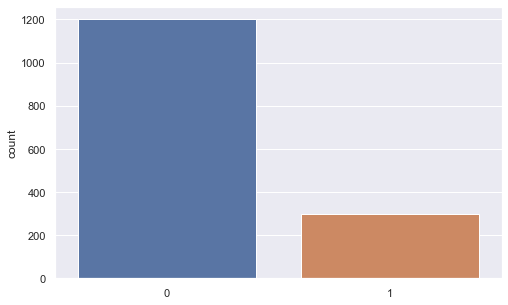

In [73]:
sns.countplot(x=y_test)

We can confirm we have accounted for data imbalanced in producing the train and test sets.

In [74]:
def report(clf, x_train, y_train, x_test, y_test, cm_norm = False, output=True):
    """
    Automates model fitting and generate reports and plots for each model
    Returns:
    clf.__class__.__name__
    accuracy, macro_precision 
    macro_recall 
    macro_f1, support
    auc_score
    """
    
    clf.fit(x_train, y_train)
    
    prediction_test = clf.predict(x_test)
    
    probs = clf.predict_proba(x_test)
    
   
    
    # Get classification metrics
    class_report = classification_report(y_test, prediction_test, output_dict=True)
    accuracy= class_report['accuracy']
    macro_precision =  class_report['macro avg']['precision'] 
    macro_recall = class_report['macro avg']['recall']    
    macro_f1 = class_report['macro avg']['f1-score']
    support= class_report['weighted avg']['support']
    
    # To get AUC when output = False
    auc_score = roc_auc_score(y_test, probs[:,1])
    
    if output == True:
        # Print the prediction accuracy
        print(classification_report(y_test, prediction_test))

        # Confusion matrix
        plot_confusion_matrix(y_test, prediction_test, classes=['complete','incomplete'], normalize=cm_norm)
        plt.show()


        # Plot normal ROC
        auc_score = plot_roc(y_test, probs[:,1], clf.__class__.__name__)
        # Plot ROC with macro and micro
        skplt.metrics.plot_roc_curve(y_test, probs)
        plt.show()
    
    return clf.__class__.__name__, accuracy, macro_precision, macro_recall, macro_f1, support, auc_score

In [75]:
def compare_models(clf_list, x_train, y_train, x_test, y_test, cm_norm = False):
    """
    Produces summary metrics of each model
    Fits models and generates reports. 
    Returns:
    report_df
    """
    
    cols = ['Algo', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Support', 'ROC Area' ]
    report_list = []
    for clf in (clf_list):
        print('Working on ===========> ' + clf.__class__.__name__)
        
        report_list.append(report(clf=clf, 
               x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, 
               cm_norm=False, output=False))
    
    report_df = pd.DataFrame(report_list, columns=cols)
    print(report_df)
    
    return report_df
    
    

## Algorithms

### Logistic Regression

In [76]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression()

              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1200
           1       0.95      0.07      0.12       300

    accuracy                           0.81      1500
   macro avg       0.88      0.53      0.51      1500
weighted avg       0.84      0.81      0.74      1500

Confusion matrix, without normalization
[[1199    1]
 [ 280   20]]


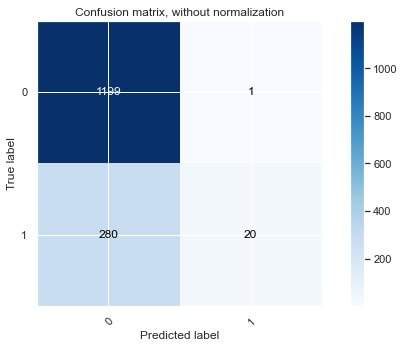

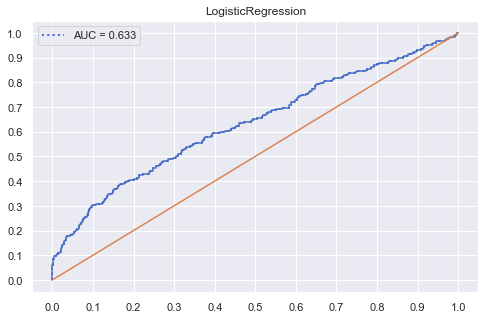

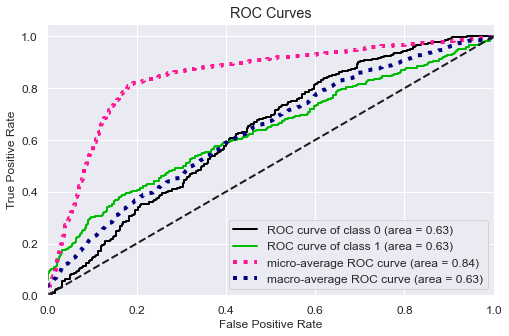

('LogisticRegression',
 0.8126666666666666,
 0.8815319231140732,
 0.5329166666666667,
 0.5098603538075652,
 1500,
 0.6326777777777778)

In [77]:
report(clf=model_log, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

#### Get the weights of all the variables

In [112]:
weights = pd.Series(model_log.coef_[0],
                 index=X.columns.values)
weights

Total Items                       2.735325
Unique Items                     -1.916758
Total Sales                       2.140035
Discounted Sales                 -0.530745
Browsing Duration (minutes)       0.294687
Number of Clicks                  0.563855
Age                               0.074636
Household Income                 -0.058439
Loyalty Card                      0.036170
Loyalty Points                    0.045323
Gender_Female                    -0.035585
Gender_Male                       0.035443
Region_Rural                      0.040003
Region_Suburban                  -0.084505
Region_Urban                      0.044360
Marital Status_Civil partnered    0.086616
Marital Status_Divorced          -0.041388
Marital Status_Married            0.037021
Marital Status_Single            -0.048505
Marital Status_Widowed           -0.033886
Education_Graduate                0.088373
Education_High School            -0.255563
Education_Post-Graduate           0.025426
Education_u

Lets visualise the coefficients provided for each variable:

AxesSubplot(0.125,0.125;0.775x0.755)


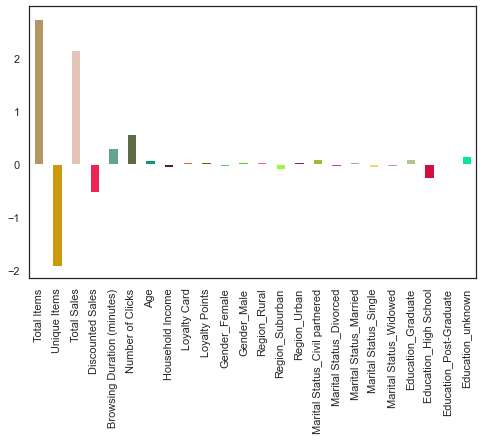

In [115]:
print (weights.plot(kind='bar', 
                    color= ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                     for i in range(24)]))

And then sort them ascending for better understanding:

AxesSubplot(0.125,0.125;0.775x0.755)


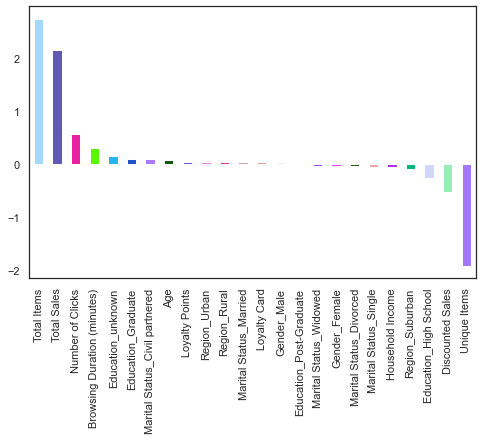

In [122]:
print (weights.sort_values(ascending = False).plot(kind='bar', 
                                                   color= ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                                                     for i in range(24)]))

We can see that some variables have a negative relation to our predicted variable, while some have positive relation. Negative relation means that likeliness of incomplete transaction decreases with that variable.

Some of the key points that we derived from the our data:
- Total sales has the highest influence on the likelihood of incomplete transaction. It means that with each unit increase in total sales likelihood of incomplete tranasction increases with 1.77 units.
- Also, browsing duration and number of clicks increase the chances of incomplete transaction per prediction from logistic regression model.
- On the other hand, unique items, discounted sales and education_High School can lead to a higher increase of complete transactionrates. For instance, each unit increase in unique items increases the chances of complete transactions for 1.66 units or in other words, it decreases the chances of incomplete transaction.

### Logistic Regression CV

In [123]:
from sklearn.linear_model import LogisticRegressionCV

model_logit_cv = LogisticRegressionCV(class_weight='balanced', cv=2, max_iter=500,
                                scoring='f1', penalty='l1', solver='liblinear',
                                n_jobs=-1, random_state=0, refit=True, verbose=0)

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      1200
           1       0.28      0.52      0.37       300

    accuracy                           0.64      1500
   macro avg       0.57      0.60      0.56      1500
weighted avg       0.74      0.64      0.67      1500

Confusion matrix, without normalization
[[802 398]
 [143 157]]


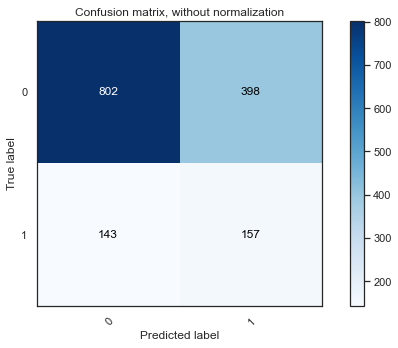

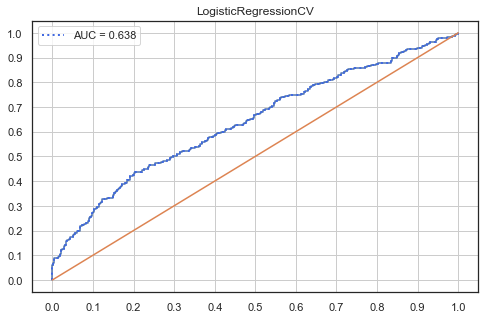

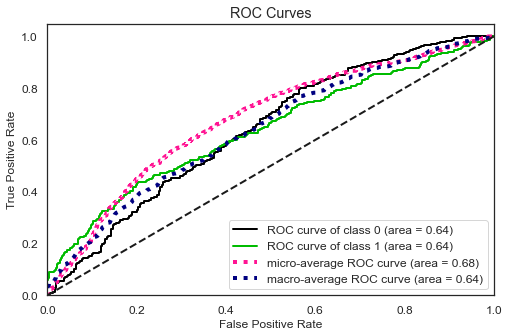

('LogisticRegressionCV',
 0.6393333333333333,
 0.5657800657800658,
 0.5958333333333333,
 0.557518504886926,
 1500,
 0.6377055555555555)

In [124]:
report(clf=model_logit_cv, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

I could not get a high accuracy hen doing cv = 2, this needs to be explored with higher numbers at least 5, maybe?

### Decision Tree


In [78]:
from sklearn.tree import DecisionTreeClassifier

model_dtree = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy',
                                       max_depth=3,
                                       random_state=0)

              precision    recall  f1-score   support

           0       0.88      0.58      0.70      1200
           1       0.29      0.69      0.41       300

    accuracy                           0.60      1500
   macro avg       0.59      0.64      0.56      1500
weighted avg       0.77      0.60      0.64      1500

Confusion matrix, without normalization
[[698 502]
 [ 92 208]]


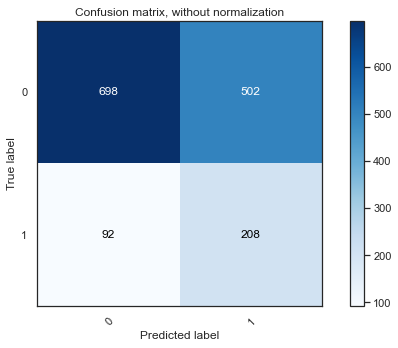

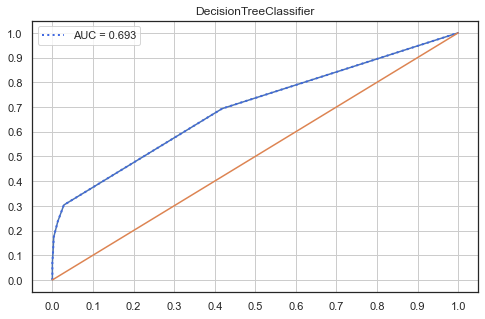

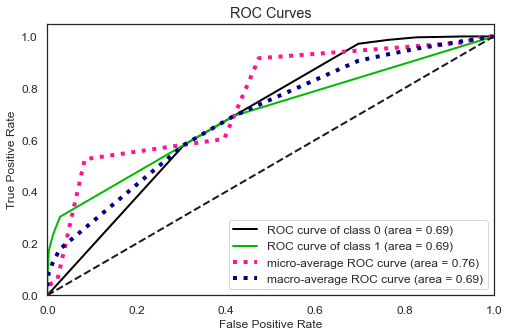

('DecisionTreeClassifier',
 0.604,
 0.5882510251381708,
 0.6375,
 0.556694362903627,
 1500,
 0.6933194444444445)

In [127]:
report(clf=model_dtree, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

### Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      1200
           1       0.86      0.20      0.33       300

    accuracy                           0.83      1500
   macro avg       0.85      0.60      0.62      1500
weighted avg       0.84      0.83      0.79      1500

Confusion matrix, without normalization
[[1190   10]
 [ 239   61]]


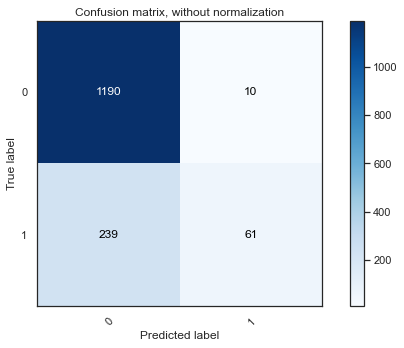

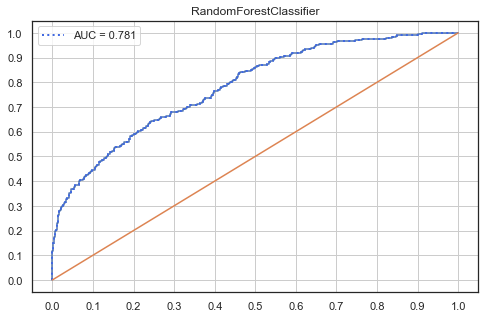

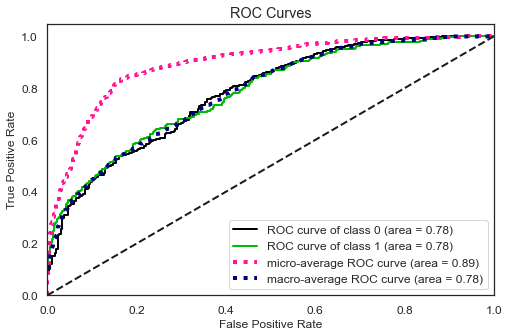

('RandomForestClassifier',
 0.834,
 0.8459525522624902,
 0.5975,
 0.6170640758941067,
 1500,
 0.7814694444444443)

In [129]:
report(clf=model_rf, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

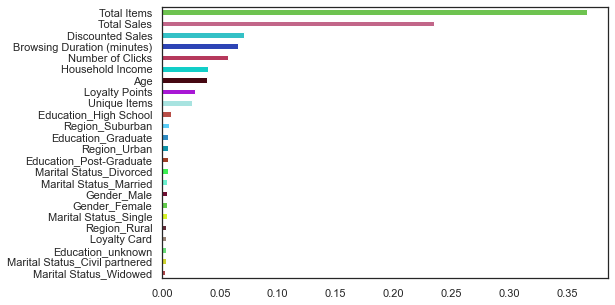

In [131]:
importances = model_rf.feature_importances_

weights = pd.Series(importances,
                 index=X.columns.values)

weights.sort_values().plot(kind = 'barh', color=["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(24)])


From random forest algorithm perpective total items, total sales and discounted les are the top three important predictors variables to predict incomplete transaction.
Interestingly high school education is not on top of the list. What we saw in earlier section.

### Grid search for RF

In [132]:
# Grid search for random forest to check if we can fine tune hyper parameters
# with cross validation
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': np.random.exponential(100, size=100),
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
    'oob_score': [True],
    'max_leaf_nodes': np.random.poisson(lam=30, size=100)
    
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 14.0min finished


              precision    recall  f1-score   support

           0       0.84      0.99      0.90      1200
           1       0.80      0.22      0.35       300

    accuracy                           0.83      1500
   macro avg       0.82      0.60      0.63      1500
weighted avg       0.83      0.83      0.79      1500

Confusion matrix, without normalization
[[1183   17]
 [ 233   67]]


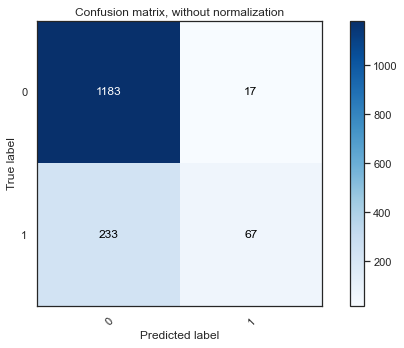

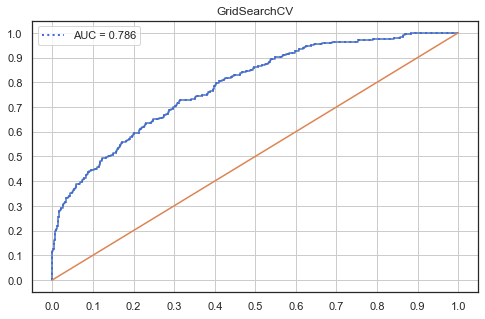

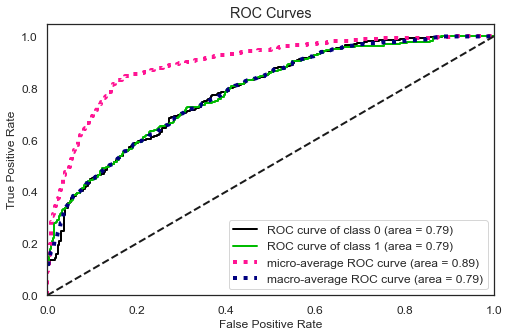

('GridSearchCV',
 0.8333333333333334,
 0.8165355125100888,
 0.6045833333333334,
 0.6266962920489296,
 1500,
 0.7862277777777777)

In [133]:
report(clf=grid_search, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

In [161]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(max_depth=110, max_leaf_nodes=40, min_samples_leaf=3,
                       min_samples_split=12, n_estimators=1000, oob_score=True)

We had slight improvement on random forest using grid search. Exploring more according to the correct distribution of which the parameters tend to surf for sure provides better result. However, we should account for overfitting.

### Support Vector Machine (SVM)

In [162]:
from sklearn.svm import SVC

model_svm = SVC(kernel='linear', probability=True) 
model_svm.fit(X_train,y_train)

# preds = model.svm.predict(X_test)
# metrics.accuracy_score(y_test, preds)
# 'Accuracy = {:0.2f}%.'.format(metrics.accuracy_score(y_test, preds)*100)

SVC(kernel='linear', probability=True)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1200
           1       0.00      0.00      0.00       300

    accuracy                           0.80      1500
   macro avg       0.40      0.50      0.44      1500
weighted avg       0.64      0.80      0.71      1500

Confusion matrix, without normalization
[[1200    0]
 [ 300    0]]


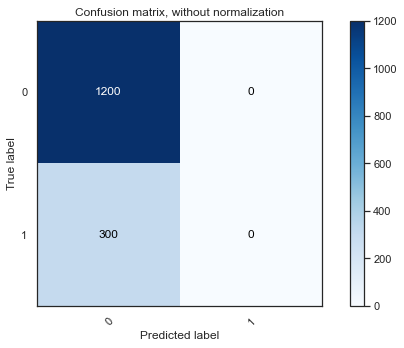

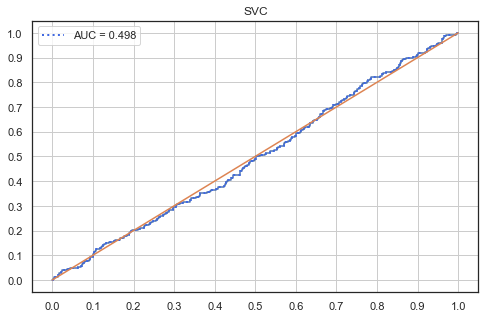

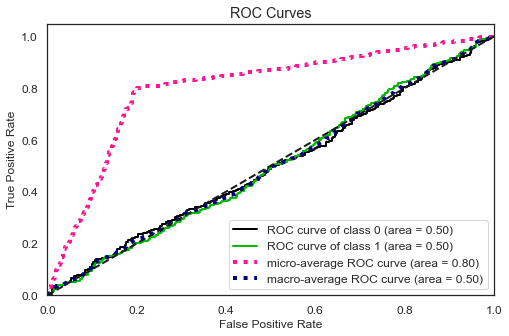

('SVC', 0.8, 0.4, 0.5, 0.4444444444444445, 1500, 0.49768055555555557)

In [163]:
report(clf=model_svm, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

As expected from SVM ROC we have a flat line. However, using specific ROC for each class we can see slight departure of the lines from 50% line.

### ADA Boost

In [164]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier()

# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1200
           1       0.66      0.31      0.42       300

    accuracy                           0.83      1500
   macro avg       0.75      0.63      0.66      1500
weighted avg       0.81      0.83      0.80      1500

Confusion matrix, without normalization
[[1152   48]
 [ 208   92]]


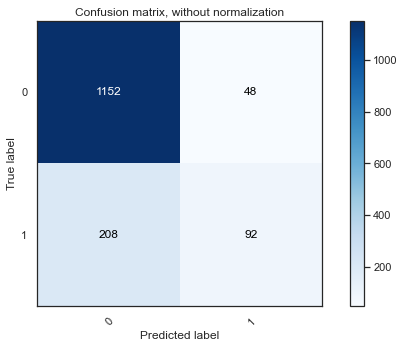

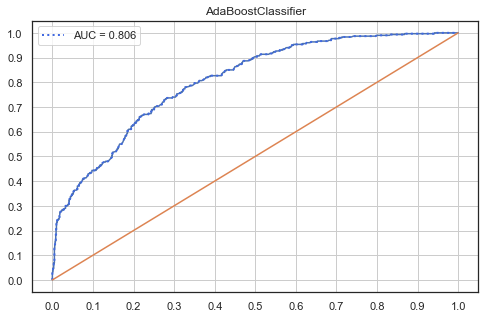

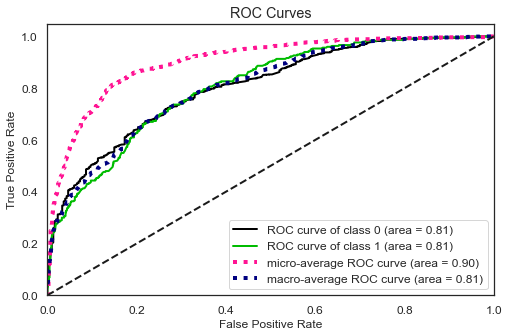

('AdaBoostClassifier',
 0.8293333333333334,
 0.7521008403361344,
 0.6333333333333333,
 0.6590909090909091,
 1500,
 0.8058152777777777)

In [165]:
report(clf=model_ada, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

### XGBoost

In [87]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [79]:
#conda install -c conda-forge xgboost
# pip install xgboost (in jupyter)
from xgboost import XGBClassifier

model_xg = XGBClassifier()


              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1200
           1       0.64      0.34      0.44       300

    accuracy                           0.83      1500
   macro avg       0.74      0.65      0.67      1500
weighted avg       0.81      0.83      0.81      1500

Confusion matrix, without normalization
[[1142   58]
 [ 198  102]]


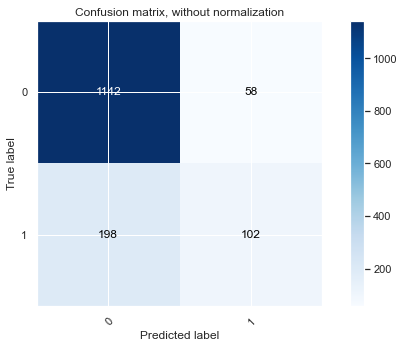

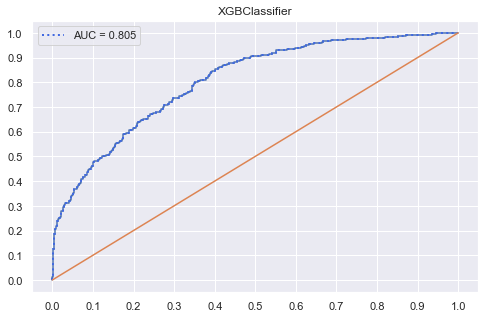

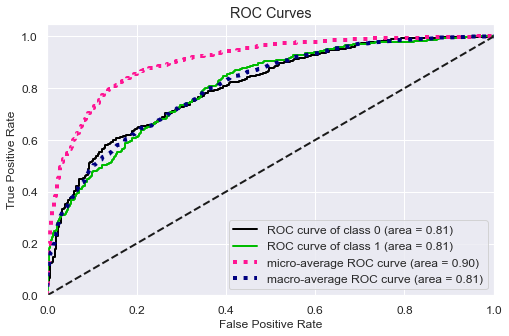

('XGBClassifier',
 0.8293333333333334,
 0.7448694029850746,
 0.6458333333333334,
 0.6713454296473811,
 1500,
 0.8053833333333333)

In [80]:
report(clf=model_xg, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)

# Model Comparison

In [169]:
# Have not included the Grid search as it takes a long time
models_df = compare_models(clf_list=[model_log, model_logit_cv, model_dtree, model_rf, model_svm, model_ada, model_xg],
              x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cm_norm=False)


Working on ===========> LogisticRegression
Working on ===========> LogisticRegressionCV
Working on ===========> DecisionTreeClassifier
Working on ===========> RandomForestClassifier
Working on ===========> SVC
Working on ===========> AdaBoostClassifier
Working on ===========> XGBClassifier
                     Algo  Accuracy  Precision    Recall  F1-score  Support  \
0      LogisticRegression  0.812667   0.881532  0.532917  0.509860     1500   
1    LogisticRegressionCV  0.639333   0.565780  0.595833  0.557519     1500   
2  DecisionTreeClassifier  0.604000   0.588251  0.637500  0.556694     1500   
3  RandomForestClassifier  0.834000   0.845953  0.597500  0.617064     1500   
4                     SVC  0.800000   0.400000  0.500000  0.444444     1500   
5      AdaBoostClassifier  0.829333   0.752101  0.633333  0.659091     1500   
6           XGBClassifier  0.829333   0.744869  0.645833  0.671345     1500   

   ROC Area  
0  0.632678  
1  0.637706  
2  0.693319  
3  0.781469  
4  0.4

In [171]:
models_df.sort_values('Accuracy', ascending=False)

,Algo,Accuracy,Precision,Recall,F1-score,Support,ROC Area
3,RandomForestClassifier,0.834000,0.845953,0.597500,0.617064,1500,0.781469
5,AdaBoostClassifier,0.829333,0.752101,0.633333,0.659091,1500,0.805815
6,XGBClassifier,0.829333,0.744869,0.645833,0.671345,1500,0.805383
0,LogisticRegression,0.812667,0.881532,0.532917,0.509860,1500,0.632678
4,SVC,0.800000,0.400000,0.500000,0.444444,1500,0.497681
1,LogisticRegressionCV,0.639333,0.565780,0.595833,0.557519,1500,0.637706
2,DecisionTreeClassifier,0.604000,0.588251,0.637500,0.556694,1500,0.693319


# Best Model

Since XGBClassifier has the best F1-score, it has the best overall performance and hence gives the right tradeoff between precision and recall. We can also see thjat ensemble models are performing slightly better compare to the others as they more robust to imbalanced data sets.

Main reason that most of the classifiers not achieving huigher accuracy scores is because the incomplete and complete trasactions are overlapping and making it difficult for the classifier to identify a perfect decision boundry without sacrificing either perision or recall. It can be easily seen from the initioal correlation plot and pairwise plot. It shows that except ew variables most of the variables correlations with response variable are not very significant. 

If the company wants to choose a model to deploy, it has to make a tradeoff between the amount of revenue it wants to retain and the amoount of revenue it is willing to spend on the making sure transaction are getting complete. For instance, increasing discount or targetting particular community of customers with related offers and promotions. This has been identified during this analysis. 
The tradeoff is a result of the tradeoff between precision and recall. Choosing higher threshold of precision helps us to target transactions with higher likelihood of getting incomplete and missing those with lower likelihood. On the other hand, sacrificing precision over recall to make sure we select higher proportion of incomplete transaction while there might be some complete among them.

# New transactions

In [94]:
transactions_new = pd.read_csv('data/new_transactions.csv')
transactions_new.head()

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks
0,TRID_25516,CID_10324,2020-01-23,12,2,11.20,5.93,6.03,11
1,TRID_18569,CID_10012,2020-03-24,3,3,10.56,7.55,9.35,18
2,TRID_97307,CID_7234,2020-01-19,7,2,22.72,5.76,6.82,14
3,TRID_52976,CID_5471,2020-02-21,7,4,16.40,9.43,7.01,13
4,TRID_10277,CID_12411,2020-01-28,4,4,11.20,8.87,6.17,12


In [95]:
transactions_new.isnull().sum()

Transaction ID                 0
Customer ID                    0
Date                           0
Total Items                    0
Unique Items                   0
Total Sales                    0
Discounted Sales               0
Browsing Duration (minutes)    0
Number of Clicks               0
dtype: int64

In [98]:
customers.isnull().sum()

Customer ID           0
Age                   0
Gender                0
Region                0
Marital Status        0
Education           184
Household Income      0
Loyalty Card          0
Loyalty Points        0
dtype: int64

In [100]:
customers['Education'] = customers['Education'].fillna('unknown')
customers['Education']

0         High School
1            Graduate
2            Graduate
3            Graduate
4             unknown
            ...      
2402         Graduate
2403         Graduate
2404         Graduate
2405    Post-Graduate
2406          unknown
Name: Education, Length: 2395, dtype: object

In [107]:
df_new = pd.merge(transactions_new, customers, left_on='Customer ID', right_on='Customer ID', how= 'left')
df_new.to_csv('df_new.csv')
df_new = pd.read_csv('data/df_new.csv')
df_new.head()

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points
0,TRID_25516,CID_10324,2020-01-23,12,2,11.20,5.93,6.03,11,54,Male,Suburban,Married,Post-Graduate,81000.0,0,15.0
1,TRID_18569,CID_10012,2020-03-24,3,3,10.56,7.55,9.35,18,57,Female,Suburban,Single,Post-Graduate,50000.0,1,31.0
2,TRID_97307,CID_7234,2020-01-19,7,2,22.72,5.76,6.82,14,42,Female,Suburban,Married,Post-Graduate,79500.0,0,15.0
3,TRID_52976,CID_5471,2020-02-21,7,4,16.40,9.43,7.01,13,69,Male,Rural,Single,High School,29000.0,0,15.0
4,TRID_10277,CID_12411,2020-01-28,4,4,11.20,8.87,6.17,12,19,Female,Suburban,Widowed,Graduate,59000.0,0,15.0


In [108]:
df_new.isnull().sum()

Transaction ID                 0
Customer ID                    0
Date                           0
Total Items                    0
Unique Items                   0
Total Sales                    0
Discounted Sales               0
Browsing Duration (minutes)    0
Number of Clicks               0
Age                            0
Gender                         0
Region                         0
Marital Status                 0
Education                      0
Household Income               0
Loyalty Card                   0
Loyalty Points                 0
dtype: int64

In [111]:
df_new_dummy = pd.get_dummies(df_new.iloc[:,3:])
df_new_dummy.head()

,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Age,Household Income,Loyalty Card,Loyalty Points,...,Region_Urban,Marital Status_Civil partnered,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education_Graduate,Education_High School,Education_Post-Graduate,Education_unknown
0,12,2,11.20,5.93,6.03,11,54,81000.0,0,15.0,...,0,0,0,1,0,0,0,0,1,0
1,3,3,10.56,7.55,9.35,18,57,50000.0,1,31.0,...,0,0,0,0,1,0,0,0,1,0
2,7,2,22.72,5.76,6.82,14,42,79500.0,0,15.0,...,0,0,0,1,0,0,0,0,1,0
3,7,4,16.40,9.43,7.01,13,69,29000.0,0,15.0,...,0,0,0,0,1,0,0,1,0,0
4,4,4,11.20,8.87,6.17,12,19,59000.0,0,15.0,...,0,0,0,0,0,1,1,0,0,0


In [115]:
features = df_new_dummy.columns.values

In [117]:
scaler = MinMaxScaler(feature_range = (0,1))

In [126]:
scaler.fit(df_new_dummy)
df_new_dummy = pd.DataFrame(scaler.transform(df_new_dummy))

In [127]:
df_new_dummy.columns = features
df_new_dummy.head()

,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Age,Household Income,Loyalty Card,Loyalty Points,...,Region_Urban,Marital Status_Civil partnered,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education_Graduate,Education_High School,Education_Post-Graduate,Education_unknown
0,0.60,0.285714,0.240326,0.327766,0.492567,0.411765,0.610169,0.898810,0.0,0.254237,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.15,0.428571,0.224033,0.440501,0.821606,0.823529,0.661017,0.529762,1.0,0.525424,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.35,0.285714,0.533605,0.315936,0.570862,0.588235,0.406780,0.880952,0.0,0.254237,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.35,0.571429,0.372709,0.571329,0.589693,0.529412,0.864407,0.279762,0.0,0.254237,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.20,0.571429,0.240326,0.532359,0.506442,0.470588,0.016949,0.636905,0.0,0.254237,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [129]:
xg_preds = model_xg.predict(df_new_dummy)

In [132]:
df_new['preds'] = xg_preds
df_new

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points,preds
0,TRID_25516,CID_10324,2020-01-23,12,2,11.20,5.93,6.03,11,54,Male,Suburban,Married,Post-Graduate,81000.0,0,15.0,1
1,TRID_18569,CID_10012,2020-03-24,3,3,10.56,7.55,9.35,18,57,Female,Suburban,Single,Post-Graduate,50000.0,1,31.0,0
2,TRID_97307,CID_7234,2020-01-19,7,2,22.72,5.76,6.82,14,42,Female,Suburban,Married,Post-Graduate,79500.0,0,15.0,1
3,TRID_52976,CID_5471,2020-02-21,7,4,16.40,9.43,7.01,13,69,Male,Rural,Single,High School,29000.0,0,15.0,0
4,TRID_10277,CID_12411,2020-01-28,4,4,11.20,8.87,6.17,12,19,Female,Suburban,Widowed,Graduate,59000.0,0,15.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TRID_70407,CID_10631,2020-03-12,5,3,14.64,6.91,7.54,14,34,Male,Rural,Widowed,High School,83500.0,0,15.0,0
996,TRID_47852,CID_5029,2020-01-25,8,3,11.44,7.93,7.19,14,54,Female,Urban,Married,Graduate,43000.0,0,15.0,0
997,TRID_4061,CID_8663,2020-03-16,3,3,10.08,7.43,6.35,12,57,Female,Urban,Single,unknown,84500.0,0,15.0,0
998,TRID_78758,CID_7821,2020-03-16,6,5,11.68,10.02,3.69,8,77,Female,Urban,Divorced,High School,52500.0,0,15.0,0


# Future Work

- More in depth exploratory data analysis
- Fine tunning hyper parameters to achieve better accuracy or F1-Score if we are interested in either recall or precision
- Include cross validation in predictions
- Define additional evaluation metrics such as percentage of monthly revenue retained.
- Analysis of type 1 and type 2 errors. For instance if we predict a transaction will be incomplete but it is actually not (type 1 error), it might be fine to have such erorrs, but we don't want to have tranactions which are going to be incomplete and we are not able to catch them (type 2 error). This can be cause by relying on a model with high accuracy but weak recall.
- As mentioned before we could use undersampling techniques to address the unbalanced/skewed  data in training set such as:
Resample the training set, Use K-fold Cross-Validation, Ensemble different resampled datasets, Resample with different ratios.
- Restructuring the code to object oriented for better structure and easier deployment.
- To use sklearn Pipeline to make it easier to feed in data to our models. We don't need to scale or modify the columns manually.  
- Avoiding pandas dataframe for our dataset structure and replacing it with Dask or parquet data structure

## Data Requirement

- To identify Most Valued Customers (MVC) or high spending customers
- To identify if both couples are working or only one has a job
- How return policy works. Sometimes customers leave the basket without checking out as they are not sure about the products and then decide to visit the store physically. This is because there is not a reliable return policy availbale and they don't want to deal with it.
- Regarding the previous note, it would be beneficial to know the customer's distance to the nearest store.
- How long we need to call a transaction incomplete? This is because customers might come back to checkout their basket after some days.

Thanks,
Sam Omidi